In [1]:
# Import könyvtárak
import json
import os
import re
from pathlib import Path
from typing import Callable, Dict, List, Sequence

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, f1_score
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import sys

In [2]:
def find_best_model(models_dir: Path):
    """Find and return path to best model checkpoint."""
    best_models = list(models_dir.glob('best_*.pt'))
    if not best_models:
        raise FileNotFoundError(f"No best_*.pt checkpoints found in {models_dir}")
    final_balanced = [m for m in best_models if 'final_balanced' in m.name.lower()]
    return final_balanced[0] if final_balanced else best_models[-1]

In [3]:
class TransformerDataset(Dataset):
    """Dataset for transformer inference."""
    def __init__(self, texts: Sequence[str], tokenizer, max_length: int = 384):
        self.texts = list(texts)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "text": text,
        }

## Robustness Testing Functions

In [4]:
def add_noise_to_text(text: str, noise_level: float = 0.1) -> str:
    """Add simple character-level noise (delete/duplicate/space)."""
    if not text or noise_level <= 0:
        return text

    text_list = list(text)
    n_chars_to_modify = max(1, int(len(text_list) * noise_level))
    rng = np.random.default_rng()

    for _ in range(n_chars_to_modify):
        if not text_list:
            break
        idx = int(rng.integers(0, len(text_list)))
        action = rng.choice(["delete", "duplicate", "space"])
        if action == "delete":
            text_list.pop(idx)
        elif action == "duplicate" and idx < len(text_list):
            text_list.insert(idx, text_list[idx])
        else:
            text_list[idx] = " "

    return "".join(text_list)

In [5]:
def truncate_text(text: str, ratio: float = 0.5) -> str:
    """Keep the first `ratio` portion of the words."""
    if not text:
        return text
    words = text.split()
    n_words = max(1, int(len(words) * ratio))
    return " ".join(words[:n_words])

In [6]:
def predict_batch(model, tokenizer, texts: Sequence[str], device: torch.device, 
                  batch_size: int = 8, id2label: Dict[int, str] = None, max_length: int = 384):
    """Run batched inference."""
    dataset = TransformerDataset(texts, tokenizer, max_length=max_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=device.type == "cuda",
    )

    predictions: List[str] = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            if id2label:
                predictions.extend([id2label[int(p)] for p in preds.cpu().numpy()])
            else:
                predictions.extend(preds.cpu().numpy().tolist())

    return predictions

In [7]:
def plot_robustness_results(results: Sequence[Dict], save_path: Path):
    """Plot bar chart of accuracies for perturbations."""
    if not results:
        return

    test_names = [r["test_name"] for r in results]
    accuracies = [r["accuracy"] for r in results]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(test_names, accuracies, color="steelblue")
    ax.set_ylabel("Accuracy")
    ax.set_title("Model Robustness Tests")
    ax.set_ylim([0, 1])
    ax.axhline(y=accuracies[0], color="red", linestyle="--", label="Baseline (Original)")

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, h, f"{h:.3f}", ha="center", va="bottom")

    plt.xticks(rotation=45, ha="right")
    ax.legend()
    fig.tight_layout()
    fig.savefig(save_path)
    plt.show()
    plt.close(fig)
    print(f"Robustness plot saved to {save_path}")

## Explainability Functions

In [8]:
def get_attention_based_importance(model, tokenizer, texts: Sequence[str], labels: Sequence[str],
                                   device: torch.device, n_examples: int, max_length: int):
    """Extract top attended tokens for examples."""
    results = []
    model.eval()
    
    for i, text in enumerate(texts[:n_examples]):
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask_tensor = encoding["attention_mask"].to(device)

        with torch.no_grad():
            # Note: This requires model to support output_attentions
            # For custom models, you may need to modify the forward pass
            try:
                outputs = model.transformer(
                    input_ids=input_ids, 
                    attention_mask=attention_mask_tensor, 
                    output_attentions=True, 
                    return_dict=True
                )
                attentions = outputs.attentions
                
                # Get model prediction
                model_output = model(input_ids=input_ids, attention_mask=attention_mask_tensor)
                logits = model_output.logits
                pred_class = int(torch.argmax(logits, dim=1)[0])
                probs = torch.softmax(logits, dim=1)[0]

                avg_attention = torch.stack([att.mean(dim=1) for att in attentions]).mean(dim=0)[0]
                tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
                attention_scores = avg_attention.mean(dim=0).cpu().numpy()

                valid_tokens: List[str] = []
                valid_scores: List[float] = []
                for token, score in zip(tokens, attention_scores):
                    if token not in ["[PAD]", "[CLS]", "[SEP]"]:
                        valid_tokens.append(token)
                        valid_scores.append(float(score))

                top_indices = np.argsort(valid_scores)[-10:][::-1]
                top_tokens = [
                    (valid_tokens[idx], valid_scores[idx]) for idx in top_indices if idx < len(valid_tokens)
                ]

                results.append(
                    {
                        "example_id": i,
                        "text_preview": text[:200] + ("..." if len(text) > 200 else ""),
                        "true_label": str(labels[i]),
                        "predicted_class_id": pred_class,
                        "prediction_probabilities": probs.cpu().numpy().tolist(),
                        "top_attended_tokens": top_tokens,
                    }
                )
            except Exception as e:
                print(f"Attention extraction failed for example {i}: {e}")
                continue

    return results

In [9]:
def analyze_misclassifications(y_true: Sequence[str], y_pred: Sequence[str], texts: Sequence[str]):
    """Analyze misclassified examples."""
    misclassified = []
    for idx, (pred, true) in enumerate(zip(y_pred, y_true)):
        if pred != true:
            misclassified.append(
                {
                    "index": idx,
                    "text": texts[idx][:200] + ("..." if len(texts[idx]) > 200 else ""),
                    "true_label": str(true),
                    "predicted_label": str(pred),
                }
            )

    confusion_pairs: Dict = {}
    for item in misclassified:
        pair = (item["true_label"], item["predicted_label"])
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    return {
        "total_misclassified": len(misclassified),
        "total_examples": len(texts),
        "error_rate": (len(misclassified) / len(texts)) if texts else 0.0,
        "confusion_pairs": [
            {"true_label": p[0], "predicted_label": p[1], "count": c}
            for p, c in sorted_pairs[:10]
        ],
        "examples": misclassified[:10],
    }

In [10]:
def plot_confusion_pairs(confusion_pairs: Sequence[Dict], save_path: Path, top_n: int = 10):
    """Plot top confusion pairs."""
    if not confusion_pairs:
        return

    pairs = confusion_pairs[:top_n]
    pair_labels = [f"{p['true_label']} → {p['predicted_label']}" for p in pairs]
    counts = [p["count"] for p in pairs]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(pair_labels, counts, color="coral")
    ax.set_xlabel("Count")
    ax.set_title("Top Confusion Pairs - Transformer")
    ax.invert_yaxis()

    for i, count in enumerate(counts):
        ax.text(count, i, f" {count}", va="center")

    fig.tight_layout()
    fig.savefig(save_path)
    plt.show()
    plt.close(fig)
    print(f"Confusion pairs plot saved to {save_path}")

## Load Model and Data

In [11]:
# Configuration
output_root = Path(os.getenv('OUTPUT_DIR', '../output'))
models_dir = output_root / "models"
data_csv = str(output_root / "processed" / "test.csv")

batch_size = 8
max_length = 384
sample_count = 10  # For attention analysis

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Load data
print(f"Loading data from {data_csv}...")
df = pd.read_csv(data_csv)
texts = df["text"].astype(str).tolist()
labels = df["label"].astype(str).tolist()

print(f"Loaded {len(texts)} test samples")
display(df.head())

Loading data from /app/output/processed/test.csv...
Loaded 701 test samples


,text,label,word_count,avg_word_len
0,3.1.4.a bank kizárja a felelősségét arra vonat...,4-Érthető,42,7.904762
1,késedelmes fizetés esetén időarányosan évi 15%...,4-Érthető,61,7.327869
2,"9.4 a felhasználó köteles lehetővé tenni, hogy...",3-Többé/kevésbé megértem,49,6.469388
3,a felhasználó a választott kellékszavatossági ...,3-Többé/kevésbé megértem,27,5.962963
4,5.1.1. egyedi hirdetési szerződéssel nem rende...,4-Érthető,185,6.664865


In [13]:
# Load model (simplified - you'd need the actual model class)
# Import BalancedFinalModel from 04 or define it here
import torch.nn as nn

class BalancedFinalModel(nn.Module):
    """Final: Balanced model."""
    def __init__(self, transformer_model, num_classes=5, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.transformer = transformer_model
        self.num_classes = num_classes
        trans_hidden = transformer_model.config.hidden_size
        
        self.adapter = nn.Sequential(
            nn.Linear(trans_hidden, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False,
            return_dict=True
        )
        hidden = outputs.last_hidden_state
        
        mask = attention_mask.unsqueeze(-1)
        summed = (hidden * mask).sum(1)
        counts = mask.sum(1).clamp(min=1)
        pooled = summed / counts
        
        adapted = self.adapter(pooled)
        logits = self.classifier(adapted)
        
        output = type('Output', (), {'logits': logits})()
        if labels is not None:
            output.loss = nn.CrossEntropyLoss()(logits, labels)
        return output

checkpoint_path = find_best_model(models_dir)
checkpoint = torch.load(checkpoint_path, map_location=device)
id2label = {int(k): v for k, v in checkpoint['id2label'].items()}

transformer_model_name = os.getenv('TRANSFORMER_MODEL', 'SZTAKI-HLT/hubert-base-cc')
base_transformer = AutoModel.from_pretrained(transformer_model_name)
model = BalancedFinalModel(base_transformer, num_classes=len(id2label))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)
print("Model loaded successfully")

Model loaded successfully


## Robustness Testing

In [14]:
# Define perturbations
perturbations = [
    {"name": "Original", "func": lambda x, **_: x, "params": {}},
    {"name": "Noise 5%", "func": add_noise_to_text, "params": {"noise_level": 0.05}},
    {"name": "Noise 10%", "func": add_noise_to_text, "params": {"noise_level": 0.10}},
    {"name": "Noise 20%", "func": add_noise_to_text, "params": {"noise_level": 0.20}},
    {"name": "Truncate 75%", "func": truncate_text, "params": {"ratio": 0.75}},
    {"name": "Truncate 50%", "func": truncate_text, "params": {"ratio": 0.50}},
    {"name": "Truncate 25%", "func": truncate_text, "params": {"ratio": 0.25}},
]

robustness_results = []

In [15]:
# Run robustness tests
for test in perturbations:
    name = test["name"]
    func: Callable = test["func"]
    params = test.get("params", {})
    print(f"Running robustness test: {name} ({params})")
    
    transformed = [func(t, **params) for t in texts]
    y_pred = predict_batch(model, tokenizer, transformed, device, batch_size=batch_size, 
                          id2label=id2label, max_length=max_length)

    labels_unique = sorted(list(set(labels) | set(y_pred)))
    report = classification_report(labels, y_pred, labels=labels_unique, output_dict=True, zero_division=0)
    
    label2id_local = {label: idx for idx, label in enumerate(labels_unique)}
    y_true_idx = [label2id_local[l] for l in labels]
    y_pred_idx = [label2id_local[l] for l in y_pred]
    macro_f1 = f1_score(y_true_idx, y_pred_idx, average="macro", zero_division=0)
    weighted_f1 = f1_score(y_true_idx, y_pred_idx, average="weighted", zero_division=0)

    robustness_results.append(
        {
            "test_name": name,
            "accuracy": float(accuracy_score(labels, y_pred)),
            "macro_f1": float(macro_f1),
            "weighted_f1": float(weighted_f1),
            "classification_report": report,
            "transformation": params,
        }
    )
    
    print(f"  Accuracy: {robustness_results[-1]['accuracy']:.4f}")

Running robustness test: Original ({})
  Accuracy: 0.0000
Running robustness test: Noise 5% ({'noise_level': 0.05})
  Accuracy: 0.0000
Running robustness test: Noise 10% ({'noise_level': 0.1})
  Accuracy: 0.0000
Running robustness test: Noise 20% ({'noise_level': 0.2})
  Accuracy: 0.0000
Running robustness test: Truncate 75% ({'ratio': 0.75})
  Accuracy: 0.0000
Running robustness test: Truncate 50% ({'ratio': 0.5})
  Accuracy: 0.0000
Running robustness test: Truncate 25% ({'ratio': 0.25})
  Accuracy: 0.0000


Robustness results saved to /app/output/advanced/robustness/robustness_results.json


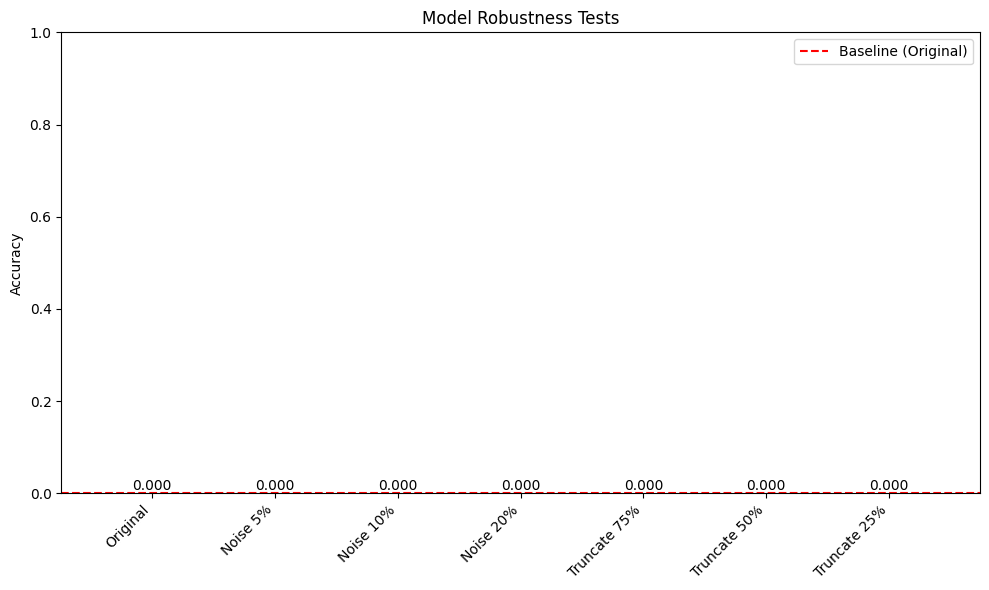

Robustness plot saved to /app/output/advanced/robustness/robustness_accuracy.png


In [16]:
# Save and plot robustness results
robustness_dir = output_root / "advanced" / "robustness"
robustness_dir.mkdir(parents=True, exist_ok=True)

json_path = robustness_dir / "robustness_results.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(robustness_results, f, ensure_ascii=False, indent=2)
print(f"Robustness results saved to {json_path}")

plot_robustness_results(robustness_results, robustness_dir / "robustness_accuracy.png")

## Explainability Analysis

In [17]:
# Run predictions for explainability
print("Running predictions for explainability...")
y_pred = predict_batch(model, tokenizer, texts, device, batch_size=batch_size, 
                      id2label=id2label, max_length=max_length)

Running predictions for explainability...


In [18]:
# Extract attention-based importance
print("Extracting attention-based importance...")
try:
    attention_results = get_attention_based_importance(
        model=model,
        tokenizer=tokenizer,
        texts=texts,
        labels=labels,
        device=device,
        n_examples=min(sample_count, len(texts)),
        max_length=max_length,
    )
    print(f"Extracted attention for {len(attention_results)} examples")
except Exception as exc:
    print(f"Attention extraction failed: {exc}")
    attention_results = []

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Extracting attention-based importance...
Extracted attention for 10 examples


In [19]:
# Save attention results
explain_dir = output_root / "advanced" / "explainability"
explain_dir.mkdir(parents=True, exist_ok=True)

if attention_results:
    attention_path = explain_dir / "attention_importance.json"
    with open(attention_path, "w", encoding="utf-8") as f:
        json.dump(attention_results, f, ensure_ascii=False, indent=2)
    print(f"Attention importance saved to {attention_path}")
    
    # Display first example
    print("\nExample attention analysis:")
    display(pd.DataFrame([attention_results[0]]))

Attention importance saved to /app/output/advanced/explainability/attention_importance.json

Example attention analysis:


,example_id,text_preview,true_label,predicted_class_id,prediction_probabilities,top_attended_tokens
0,0,3.1.4.a bank kizárja a felelősségét arra vonat...,4-Érthető,3,"[0.018069002777338028, 0.08520735800266266, 0....","[(bank, 0.08881612867116928), (., 0.0187052395..."


In [20]:
# Analyze misclassifications
print("Analyzing misclassifications...")
misclass = analyze_misclassifications(labels, y_pred, texts)

print(f"\nMisclassification Summary:")
print(f"Total misclassified: {misclass['total_misclassified']} / {misclass['total_examples']}")
print(f"Error rate: {misclass['error_rate']:.2%}")

misclass_path = explain_dir / "misclassification_analysis.json"
with open(misclass_path, "w", encoding="utf-8") as f:
    json.dump(misclass, f, ensure_ascii=False, indent=2)
print(f"Misclassification analysis saved to {misclass_path}")

Analyzing misclassifications...

Misclassification Summary:
Total misclassified: 701 / 701
Error rate: 100.00%
Misclassification analysis saved to /app/output/advanced/explainability/misclassification_analysis.json


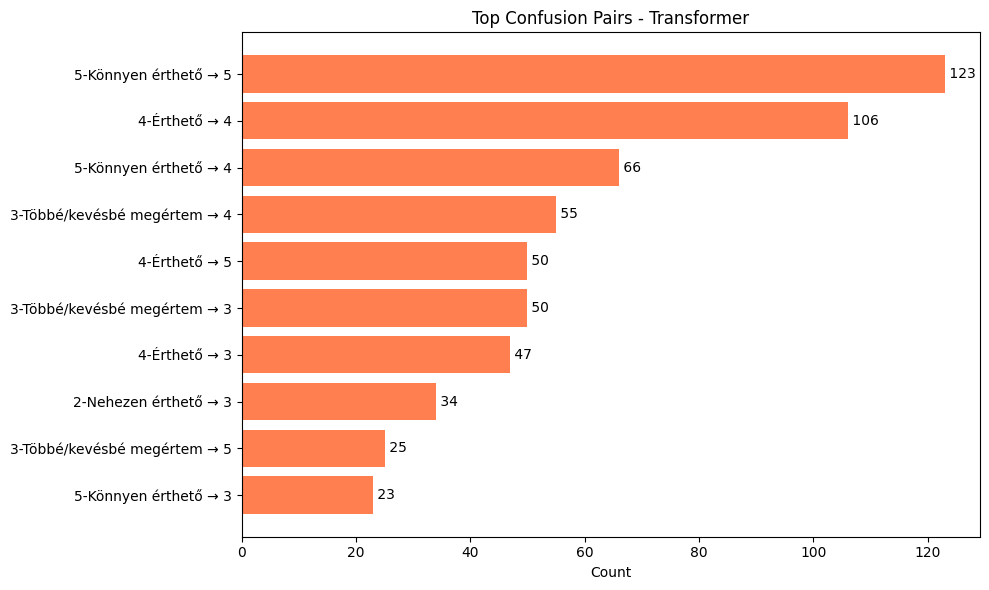

Confusion pairs plot saved to /app/output/advanced/explainability/confusion_pairs.png

Top Confusion Pairs:


,true_label,predicted_label,count
0,5-Könnyen érthető,5,123
1,4-Érthető,4,106
2,5-Könnyen érthető,4,66
3,3-Többé/kevésbé megértem,4,55
4,4-Érthető,5,50


In [21]:
# Plot confusion pairs
if misclass.get("confusion_pairs"):
    plot_confusion_pairs(misclass["confusion_pairs"], explain_dir / "confusion_pairs.png")
    
    # Display top confusion pairs
    print("\nTop Confusion Pairs:")
    display(pd.DataFrame(misclass["confusion_pairs"][:5]))

## Advanced Evaluation Complete!

Robustness testing és explainability analysis befejezve.